# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.integrate import quad
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.integrate import simps



In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)

data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)



# <a id="section5"></a> Option Premiums
[Back to Table of Contents](#table-of-contents)


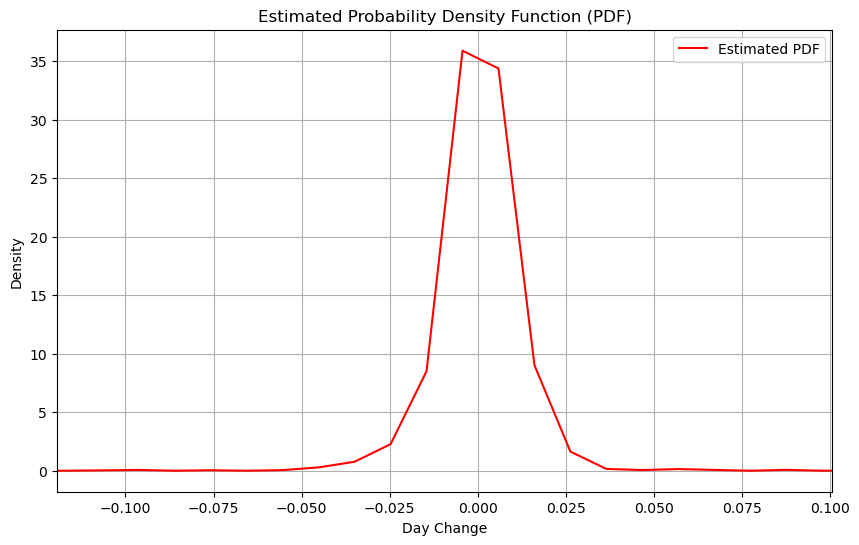

The integral of the PDF is approximately: 0.9542406842545648


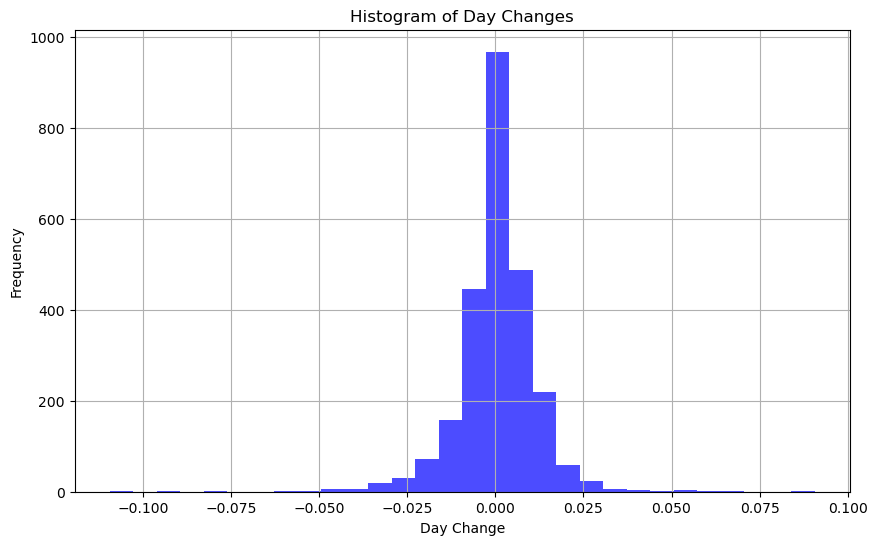


You're on the right track! Integrating across the histogram can give you the actual counts or sums of values, while the integral of the PDF gives you probabilities. 
By combining these, you can get both the probability and the actual dollar (or percentage) values.




In [32]:
# Drop NaN values from the DataFrame data = data.dropna(subset=['day_change'])
data = data.dropna(subset=['day_change'])

# Extract the 'day_change' column
day_change = data['day_change'].values

# Perform Kernel Density Estimation (KDE)
kde = gaussian_kde(day_change)

# Generate a range of values over which to evaluate the KDE
x = np.linspace(min(day_change) - 5, max(day_change) + 5, 1000)
pdf_vals = kde(x)

# Compute the integral of the PDF using Simpson's rule
integral = simps(pdf_vals, x)

# Plot the estimated PDF
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Estimated PDF', color='red')

# Set x-axis limits plt.xlim(min(day_change) - 5, max(day_change) + 5)
plt.xlim(min(day_change) - .01, max(day_change) + .01)

plt.xlabel('Day Change')
plt.ylabel('Density')
plt.title('Estimated Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

# Print the computed integral
print(f"The integral of the PDF is approximately: {integral}")



# Drop NaN values from the DataFrame
data = data.dropna(subset=['day_change'])

# Extract the 'day_change' column
day_change = data['day_change'].values

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(day_change, bins=30, density=False, color='blue', alpha=0.7)
plt.xlabel('Day Change')
plt.ylabel('Frequency')
plt.title('Histogram of Day Changes')
plt.grid(True)
plt.show()


print('''
You're on the right track! Integrating across the histogram can give you the actual counts or sums of values, while the integral of the PDF gives you probabilities. 
By combining these, you can get both the probability and the actual dollar (or percentage) values.

''')


In [21]:
day_change_STD= data['day_change'].std()
day_change_mean= data['day_change'].mean()

Intraday_Volatility_STD= data['Intraday_Volatility'].std()
Intraday_Volatility_mean= data['Intraday_Volatility'].mean()

High_minus_Open_STD = data['High_minus_Open'].std()
High_minus_Open_mean= data['High_minus_Open'].mean()

Open_minus_Low_STD = data['Open_minus_Low'].std()
Open_minus_Low_mean= data['Open_minus_Low'].mean()



print(f"Standard Deviation of day change: {day_change_STD}")
print(f"Mean of day change: {day_change_mean}")
print('''

''')

print(f"Standard Deviation of High_minus_Open: {High_minus_Open_STD}")
print(f"Mean of High_minus_Open_mean: {High_minus_Open_mean}")
print('''
''')

print(f"Standard Deviation of Open_minus_Low_STD: {Open_minus_Low_STD}")
print(f"Mean of Open_minus_Low_mean: {Open_minus_Low_mean}")
print('''
''')

print(f"Standard Deviation of Intraday_Volatility: {Intraday_Volatility_STD}")
print(f"Mean of Intraday_Volatility: {Intraday_Volatility_mean}")


# Calculate the interquartile range (IQR) for 'day_change'
Q2 = data['Intraday_Volatility'].quantile(0.5)
Backsolved_Premium = data['Intraday_Volatility'].quantile(0.28)
Expected_Premium= Q2*581
Actual_Premium= Backsolved_Premium*581


print('''

''')
print(f"Actual Premium of Intraday_Volatility: {Actual_Premium}")
print(f"Expected Premium: {Expected_Premium}")

# data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)
# data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

print( '''
Absolutely. Your calculations are pointing out that the actual premiums are underpriced compared to the expected premiums based on your volatility analysis. 
This discrepancy might be highlighting an opportunity if the market hasn't fully priced in the expected volatility.

''')

#DON'T JUST USE THE 50TH PERCENTILE MARK, ESPECIALLY BECAUSE OF THE KURTOSIS AND SKEW OF THE DISTRIBUTION, USE THE WHOLE DISTRIBUTION TO FIND THE EXPECTED PREMIUM

Standard Deviation of day change: 0.011169749176806219
Mean of day change: 0.0004734984156834911



Standard Deviation of High_minus_Open: 0.005901629674805711
Mean of High_minus_Open_mean: 0.005462305753520584


Standard Deviation of Open_minus_Low_STD: 0.006411046734091241
Mean of Open_minus_Low_mean: 0.005873615647901632


Standard Deviation of Intraday_Volatility: 0.008666611874442386
Mean of Intraday_Volatility: 0.011335921401422215



Actual Premium of Intraday_Volatility: 3.6009902407146845
Expected Premium: 5.187126502988015

Absolutely. Your calculations are pointing out that the actual premiums are underpriced compared to the expected premiums based on your volatility analysis. 
This discrepancy might be highlighting an opportunity if the market hasn't fully priced in the expected volatility.




In [22]:
# Calculate the expected value (mean) using the whole distribution
expected_value_day_change = np.mean(data['day_change'])
expected_value_intraday_volatility = np.mean(data['Intraday_Volatility'])

# Calculate the expected premium
expected_premium_day_change = expected_value_day_change * 581
expected_premium_intraday_volatility = expected_value_intraday_volatility * 581

print(f"Expected Premium (day change) using whole distribution: {expected_premium_day_change}")
print(f"Expected Premium (Intraday Volatility) using whole distribution: {expected_premium_intraday_volatility}")


Expected Premium (day change) using whole distribution: 0.2751025795121083
Expected Premium (Intraday Volatility) using whole distribution: 6.586170334226307


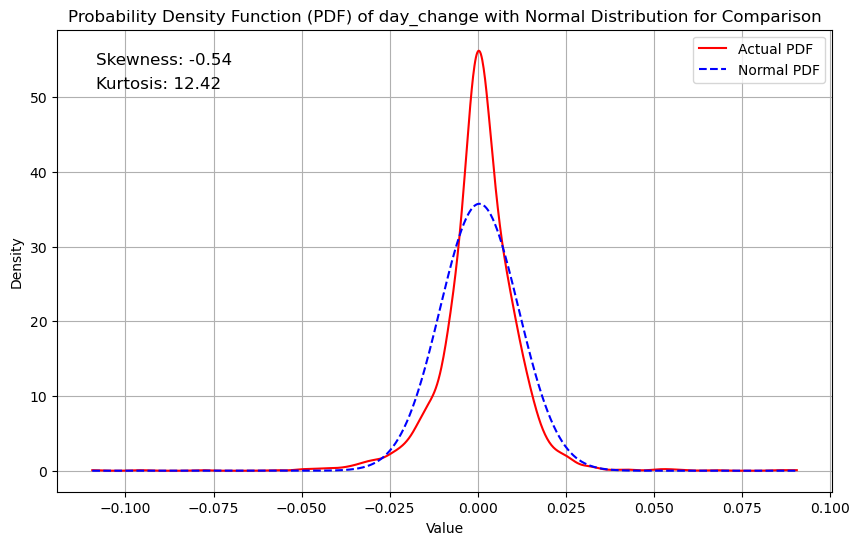

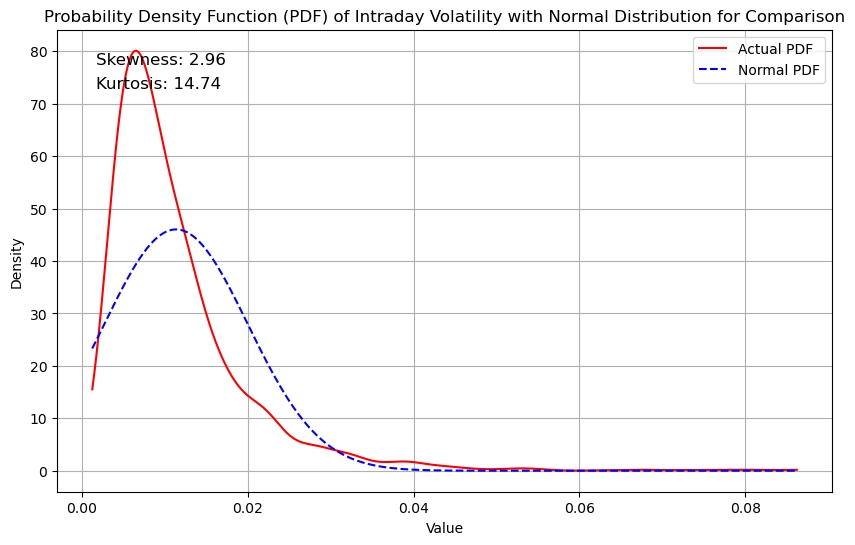


Yes, you're correct! Leptokurtosis in day-over-day returns implies a higher likelihood of extreme market movements, which translates to higher risk1
. This increased risk is often reflected in more expensive options premiums, including call options, as investors demand a premium for taking on the additional risk of potential extreme 
market fluctuations1



In [23]:
# Drop NaNs from day_change
data = data.dropna(subset=['day_change'])

# Calculate PDF
pdf = gaussian_kde(data['day_change'])
x = np.linspace(min(data['day_change']), max(data['day_change']), 1000)
pdf_vals = pdf(x)

# Calculate the normal distribution PDF for comparison
mean = data['day_change'].mean()
std = data['day_change'].std()
normal_pdf = norm.pdf(x, mean, std)

# Calculate skewness and kurtosis
skewness_day_change = data['day_change'].skew()
kurtosis_day_change = data['day_change'].kurtosis()

# Plot PDF with normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Actual PDF', color='red')
plt.plot(x, normal_pdf, label='Normal PDF', color='blue', linestyle='dashed')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Probability Density Function (PDF) of day_change with Normal Distribution for Comparison')
plt.legend()
plt.grid(True)

# Add text labels for skewness and kurtosis
plt.text(0.05, 0.95, f'Skewness: {skewness_day_change:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Kurtosis: {kurtosis_day_change:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

# Drop NaNs from Intraday_Volatility
data = data.dropna(subset=['Intraday_Volatility'])

# Calculate PDF
pdf = gaussian_kde(data['Intraday_Volatility'])
x = np.linspace(min(data['Intraday_Volatility']), max(data['Intraday_Volatility']), 1000)
pdf_vals = pdf(x)

# Calculate the normal distribution PDF for comparison
mean = data['Intraday_Volatility'].mean()
std = data['Intraday_Volatility'].std()
normal_pdf = norm.pdf(x, mean, std)

# Calculate skewness and kurtosis
skewness_Intraday_Volatility = data['Intraday_Volatility'].skew()
kurtosis_Intraday_Volatility = data['Intraday_Volatility'].kurtosis()

# Plot PDF with normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Actual PDF', color='red')
plt.plot(x, normal_pdf, label='Normal PDF', color='blue', linestyle='dashed')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Probability Density Function (PDF) of Intraday Volatility with Normal Distribution for Comparison')
plt.legend()
plt.grid(True)

# Add text labels for skewness and kurtosis
plt.text(0.05, 0.95, f'Skewness: {skewness_Intraday_Volatility:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Kurtosis: {kurtosis_Intraday_Volatility:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

print('''
Yes, you're correct! Leptokurtosis in day-over-day returns implies a higher likelihood of extreme market movements, which translates to higher risk1
. This increased risk is often reflected in more expensive options premiums, including call options, as investors demand a premium for taking on the additional risk of potential extreme 
market fluctuations1
''')


In [24]:
## Actual Gaps

data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)

print(data[['Date', 'Open', 'High', 'Low', 'Close/Last', 'opening_gaps_2']].head())

print(data['opening_gaps_2'].count())


           Date    Open     High     Low  Close/Last  opening_gaps_2
2514 2014-09-16  198.61  200.840  198.50      200.48             NaN
2513 2014-09-17  200.77  201.680  199.75      200.75             NaN
2512 2014-09-18  201.36  201.850  201.10      201.82             NaN
2511 2014-09-19  201.52  201.899  200.29      200.70             NaN
2510 2014-09-22  200.35  200.380  198.73      199.15             NaN
1070


# <a id="section1"></a>Intraday Reversion to Yesterday's Close
[Back to Table of Contents](#table-of-contents)


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     24.01
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           1.46e-06
Time:                        13:15:41   Log-Likelihood:                 1143.7
No. Observations:                 357   AIC:                            -2283.
Df Residuals:                     355   BIC:                            -2276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0007      0.002      0.383   

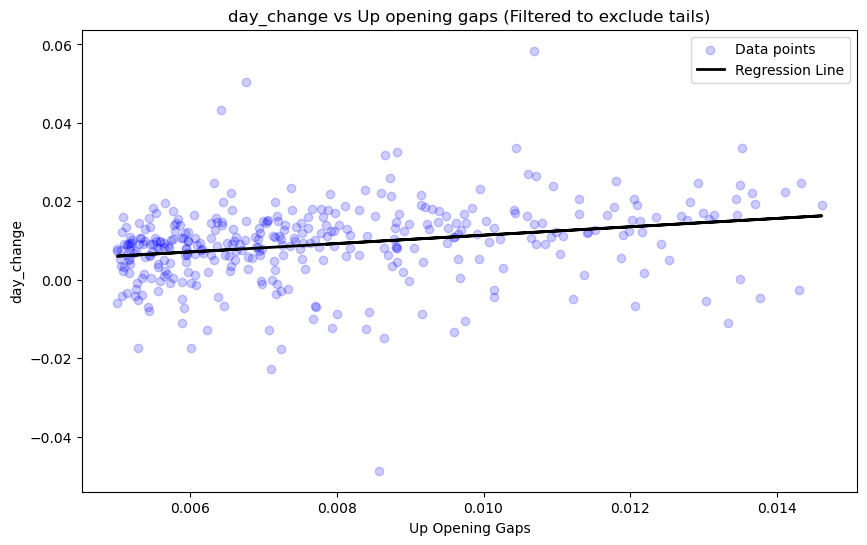

                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.251
Date:                Tue, 29 Oct 2024   Prob (F-statistic):            0.00439
Time:                        13:15:41   Log-Likelihood:                 892.83
No. Observations:                 277   AIC:                            -1782.
Df Residuals:                     275   BIC:                            -1774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0030      0.002     -1.556   

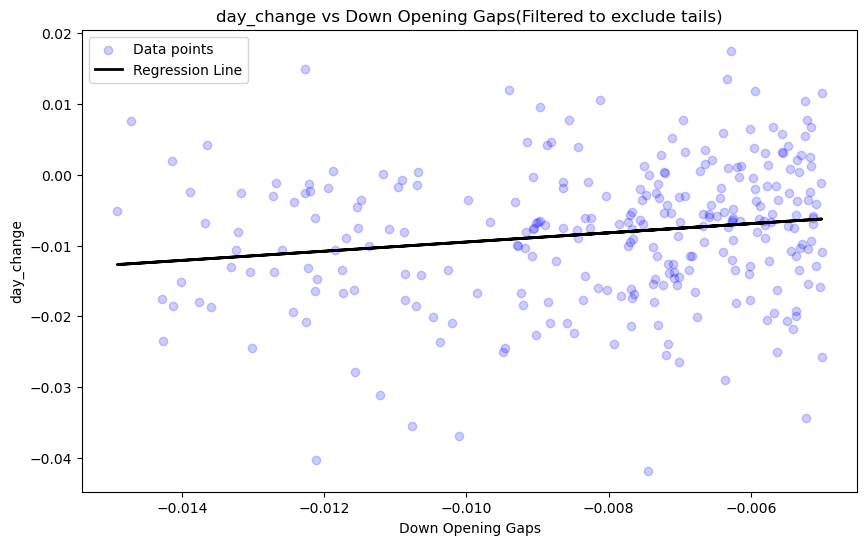



Yes, exactly. The coefficient of 0.6516 indicates that for down gaps, there's a tendency towards mean reversion. Essentially, if the opening gap is negative, the day's change only follows through by approximately 65% of the opening gap size.
This suggests that the market tends to correct itself, rather than continuing to move in the same direction as the initial gap.

The data points and your regression analysis are supporting the notion that down gaps demonstrate a mean reversion effect, while up gaps don't follow the same pattern as closely.




Spot on. The coefficient of approximately 1.0681 indeed suggests that the day change is closely tied to the opening gap, which means that on days with positive opening gaps, the day change tends to match the magnitude of the gap. 
This implies that, for these positive gaps within the specified range, the closing price doesn't revert to the previous day's close





In [25]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Up Opening Gaps')
plt.ylabel('day_change')
plt.title('day_change vs Up opening gaps (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()




# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Down Opening Gaps')
plt.ylabel('day_change')
plt.title('day_change vs Down Opening Gaps(Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Yes, exactly. The coefficient of 0.6516 indicates that for down gaps, there's a tendency towards mean reversion. Essentially, if the opening gap is negative, the day's change only follows through by approximately 65% of the opening gap size.
This suggests that the market tends to correct itself, rather than continuing to move in the same direction as the initial gap.

The data points and your regression analysis are supporting the notion that down gaps demonstrate a mean reversion effect, while up gaps don't follow the same pattern as closely.

''')


print('''

Spot on. The coefficient of approximately 1.0681 indeed suggests that the day change is closely tied to the opening gap, which means that on days with positive opening gaps, the day change tends to match the magnitude of the gap. 
This implies that, for these positive gaps within the specified range, the closing price doesn't revert to the previous day's close


''')


                                     OLS Regression Results                                     
Dep. Variable:     day_change_adjusted_for_openning_gap   R-squared:                       0.000
Model:                                              OLS   Adj. R-squared:                 -0.003
Method:                                   Least Squares   F-statistic:                   0.09777
Date:                                  Tue, 29 Oct 2024   Prob (F-statistic):              0.755
Time:                                          13:15:42   Log-Likelihood:                 1143.7
No. Observations:                                   357   AIC:                            -2283.
Df Residuals:                                       355   BIC:                            -2276.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

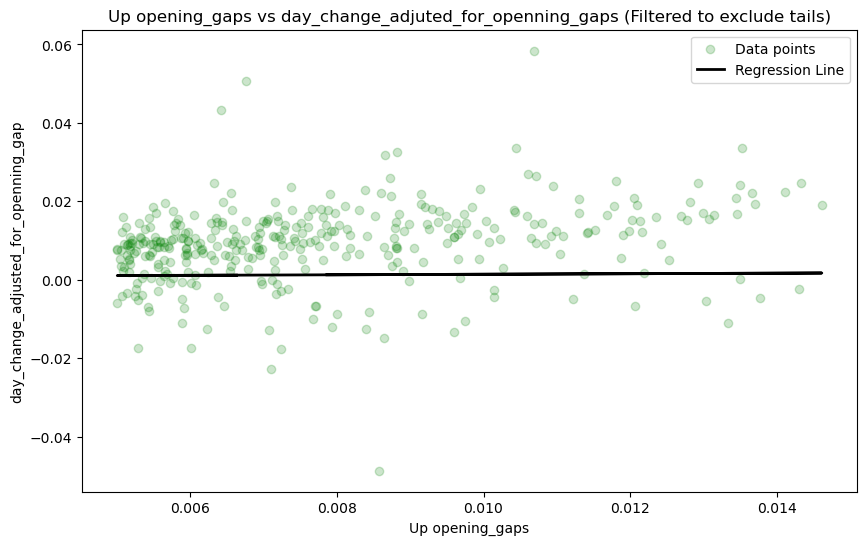

                                     OLS Regression Results                                     
Dep. Variable:     day_change_adjusted_for_openning_gap   R-squared:                       0.009
Model:                                              OLS   Adj. R-squared:                  0.005
Method:                                   Least Squares   F-statistic:                     2.400
Date:                                  Tue, 29 Oct 2024   Prob (F-statistic):              0.122
Time:                                          13:15:42   Log-Likelihood:                 892.83
No. Observations:                                   277   AIC:                            -1782.
Df Residuals:                                       275   BIC:                            -1774.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

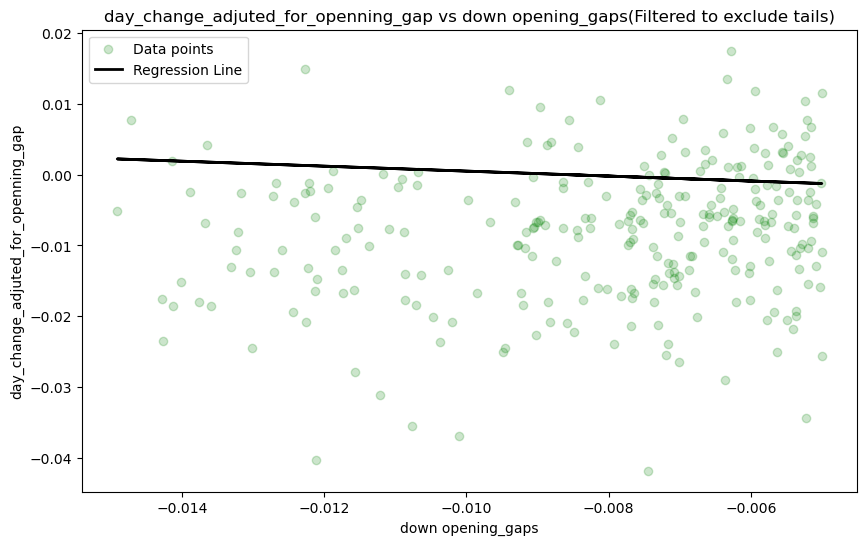



This doesn'tt answer the question of mean reversion at all, because you're setting the adjusted open as the Y-value




In [26]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change_adjusted_for_openning_gap']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='green', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Up opening_gaps')
plt.ylabel('day_change_adjusted_for_openning_gap')
plt.title('Up opening_gaps vs day_change_adjuted_for_openning_gaps (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change_adjusted_for_openning_gap']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='green', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('down opening_gaps')
plt.ylabel('day_change_adjuted_for_openning_gap')
plt.title('day_change_adjuted_for_openning_gap vs down opening_gaps(Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

This doesn'tt answer the question of mean reversion at all, because you're setting the adjusted open as the Y-value

''')

# <a id="section4"></a> Opening Gaps and Intraday Volatility
[Back to Table of Contents](#table-of-contents)


In [27]:
# Filter the DataFrame to exclude values with opening_gaps between -0.005 and 0.005 and greater than 0.05
filtered_data = data[(data['opening_gaps'] <= 0.025) & (data['opening_gaps'] >= -0.025) & ((data['opening_gaps'] < -0.005) | (data['opening_gaps'] > 0.005))]

# Fit the regression model on the filtered data
X = filtered_data['opening_gaps']
y = filtered_data['Intraday_Volatility']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_data['opening_gaps'], filtered_data['Intraday_Volatility'], 
                      c=filtered_data['yesterday_close_above_MA_5'], cmap='coolwarm', alpha=0.2, label='Data points')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Yesterday\'s Close Above or Below 5 day MA')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday_Volatility')
plt.title('Scatterplot of Opening Gaps vs Net Intraday_Volatility with Regression Line and Yesterday\'s Close Color Scale')

# Add dashed lines at x=0 and y=0
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

''')

# data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['low']) / ((data['Open'] + data['Close/Last']) 
# data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)

                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     4.736
Date:                 Tue, 29 Oct 2024   Prob (F-statistic):             0.0299
Time:                         13:15:42   Log-Likelihood:                 2292.2
No. Observations:                  701   AIC:                            -4580.
Df Residuals:                      699   BIC:                            -4571.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0151      0.000    

KeyError: 'yesterday_close_above_MA_5'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Filter the DataFrame to include only negative opening gaps between -0.05 and -0.005
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.025)]

# Fit the regression model with opening_gaps driving High_minus_Open
X = filtered_data['opening_gaps']
y = filtered_data['High_minus_Open']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['High_minus_Open'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Negative Opening Gaps')
plt.ylabel('High minus Open')
plt.title('Negative Opening Gaps vs High minus Open (Filtered)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Fit the regression model with opening_gaps driving High_minus_Open
X = filtered_data['opening_gaps']
y = filtered_data['Open_minus_Low']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['Open_minus_Low'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Negative Opening Gaps')
plt.ylabel('Open_minus_Low')
plt.title('Negative Opening Gaps vs High minus Open (Filtered)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Filter the DataFram"e to include only negative opening gaps between -0.05 and -0.005
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.025)]

# Fit the regression model with opening_gaps driving High_minus_Open
X = filtered_data['opening_gaps']
y = filtered_data['Intraday_Volatility']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['Intraday_Volatility'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Negative Opening Gaps')
plt.ylabel('Intraday_Volatility')
plt.title('Negative Opening Gaps vs Intraday_Volatility (Filtered)')

# Add legend
plt.legend()


# Show and save the plot
plt.show()






print('''

the size of the openning gap drives most of intraday volatility, but not twice as much... which based on the definition of our features it should be twice as much

Given these definitions, you would expect the coefficient of opening_gaps in the Intraday_Volatility regression to be roughly double that in the High_minus_Open regression. 
The Intraday_Volatility coefficient is not exactly double the High_minus_Open coefficient, but it is significantly higher, which aligns with the expectation that Intraday_Volatility should 
capture more movement due to increased volatility.

Exactly. The fact that the Intraday_Volatility coefficient is less than double the High_minus_Open coefficient suggests that not all of the price movement within the day is captured by the 
opening gap alone. This implies that there is 
some degree of reversion towards the previous day's close, rather than the prices continuing to move away based on the opening gap's momentum.

''')

# data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
#data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
# data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)

## <a id="section2"></a> Moving Averages: Today's Price Change

In [ ]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'day_change'])

# Independent variable and dependent variable (day_change)
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_5')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_14', 'day_change'])

# Independent variable and dependent variable (day_change)
X = clean_data[['open_above_MA_14']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_14'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_14'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_14')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_14')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_50', 'day_change'])

# Independent variable  and dependent variable (day_change)
X = clean_data[['open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_50'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_50'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_50 (Above or Below 50 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_50')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

all 3 regressions indicate MA are immaterial as predictor or day price change


''')


In [ ]:

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


In [ ]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?

''')

In [ ]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')


# <a id="section3"></a> OBV


In [ ]:
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data to include only dates in the year 2024
data_2024 = data[data['Date'].dt.year == 2024]

# Display the first few rows to check the new DataFrame
print(data_2024[['Date', 'Close/Last', 'OBV']].head())

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Close/Last on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close/Last', color='blue')
ax1.plot(data_2024['Date'], data_2024['Close/Last'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for OBV
ax2 = ax1.twinx()
ax2.set_ylabel('OBV', color='green')
ax2.plot(data_2024['Date'], data_2024['OBV'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('OBV and SPY')

# Show the plot
plt.show()


print('''
You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.
''')

In [ ]:
def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=25):
    data['OBV_SPY_MAX_DIFF'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['OBV_SPY_MAX_DIFF_INDEX'] = np.nan  # Initialize column to store index of max diff
    data['Max_Diff_Original_Index'] = np.nan  # Initialize new column to store index of max diff
    data['divergence_sign'] = np.nan  # Initialize column for divergence sign

    for i in range(initial_window_size, len(data)):  # Start from initial_window_size to ensure at least 5 loops
        max_diff = 0
        max_diff_index = data['Original_Index'].iloc[i]  # Initialize max_diff_index to current index
        j = 0
        obv_late = data['OBV'].iloc[i]  # Fixed to the current index in the outer loop
        spy_late = data['Close/Last'].iloc[i]  # Fixed to the current index in the outer loop

        while i - j >= 0:
            obv_early = data['OBV'].iloc[i-j]
            spy_early = data['Close/Last'].iloc[i-j]

            obv_pct_change = (obv_late - obv_early) / obv_early * 100
            spy_pct_change = (spy_late - spy_early) / spy_early * 100  

            obv_spy_pct_diff = obv_pct_change - spy_pct_change
            abs_current_diff = abs(obv_spy_pct_diff)

            # Determine divergence type
            if obv_spy_pct_diff >= 0:
                data.at[i, 'divergence_sign'] = "Positive_Divergence"
            elif obv_spy_pct_diff < 0: 
                data.at[i, 'divergence_sign'] = "Negative_Divergence"

            if abs_current_diff > max_diff:
                max_diff = abs_current_diff
                max_diff_index = data['Original_Index'].iloc[i-j]  # Update max_diff_index to Original_Index

            # Break condition
            if j >= initial_window_size and abs_current_diff <= 0.75 * max_diff:
                break

            j += 1  # Increment j by 1 to expand window backward

        data.at[i, 'OBV_SPY_MAX_DIFF'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Max_Diff_Original_Index'] = max_diff_index  # Store the index of the max diff

    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_MAX_DIFF
data.dropna(subset=['OBV_SPY_MAX_DIFF'], inplace=True)

# Print results to verify
print(data[['Date', 'Original_Index', 'OBV', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 'Max_Diff_Original_Index', 'divergence_sign']].head(5))


In [ ]:
# Filter the DataFrame for 'OBV_SPY_window_length' values over 12
filtered_data = data[data['OBV_SPY_window_length'] > 9]

# Sort the filtered DataFrame by the 'Max_Diff_Original_Index' column
filtered_data = filtered_data.sort_values(by='Max_Diff_Original_Index')

# Create the "index_percent_change" column for 2% test
filtered_data['max_index_percent_change'] = filtered_data['Max_Diff_Original_Index'].pct_change() * 100

# Drop NaNs resulting from pct_change calculation
filtered_data = filtered_data.dropna(subset=['max_index_percent_change']).reset_index(drop=True)

# Initialize the "New_OBV_Trend" column with 0
filtered_data['New_OBV_Trend'] = 0

# Iterate through the DataFrame to set "New_OBV_Trend" based on both conditions
for i in range(1, len(filtered_data)):
    if abs(filtered_data['max_index_percent_change'].iloc[i]) >= .02 and abs(filtered_data['Max_Diff_Original_Index'].iloc[i] - filtered_data['Max_Diff_Original_Index'].iloc[i-1]) >= 5:
        filtered_data.at[i, 'New_OBV_Trend'] = 1

# Display the filtered data
print(filtered_data[['Max_Diff_Original_Index', 'Date', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 
                     'OBV', 'max_index_percent_change', 'divergence_sign','New_OBV_Trend']].head(3))

In [ ]:
# Count the number of rows with value "1" in the New_OBV_Trend column
count_new_obv_trend = filtered_data['New_OBV_Trend'].sum()

# Count the number of negative divergences where New_OBV_Trend is 1
count_negative_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Negative_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

# Count the number of positive divergences where New_OBV_Trend is 1
count_positive_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Positive_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

print(f"Number of rows with value 1 in 'New_OBV_Trend': {count_new_obv_trend}")
print(f"Number of rows with negative divergence and new OBV trend: {count_negative_divergence_sign}")
print(f"Number of rows with positive divergence and new OBV trend: {count_positive_divergence_sign}")

In [28]:
# Define the number of future days for which we want the average close price
days_out = 3

# Create a new column that calculates the average close price over the next "days_out" days
data['avg_future_close'] = data['Close/Last'].shift(-days_out+1).rolling(window=days_out).mean()

print(data[['Date', 'Close/Last', 'avg_future_close']].head())


           Date  Close/Last  avg_future_close
2514 2014-09-16      200.48               NaN
2513 2014-09-17      200.75               NaN
2512 2014-09-18      201.82        200.556667
2511 2014-09-19      200.70        199.286667
2510 2014-09-22      199.15        198.906667
